# PMW 2A products

In this tutorial, we will provide the foundations to use GPM-API to download, manipulate and analyze data from the Global Precipitation Measurement (GPM) PMW 2A products.

Please note that GPM-API also enable access and analysis tools for the entire GPM constellation of passive microwave sensors as well as the IMERG precipitation products.
For detailed information and additional tutorials, please refer to the others [GPM-API tutorials](https://gpm-api.readthedocs.io/en/latest/04_tutorials.html).

First, let's import the package required in this tutorial.

In [ ]:
import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import ximage  # noqa

import gpm
from gpm.utils.geospatial import (
    get_circle_coordinates_around_point,
    get_country_extent,
    get_geographic_extent_around_point,
)

Using the `available_products` function, users can obtain a list of all GPM products that can be downloaded and opened into CF-compliant xarray datasets.

In [ ]:
gpm.available_products(product_types="RS")  # research products

['1A-GMI',
 '1A-TMI',
 '1B-GMI',
 '1B-Ka',
 '1B-Ku',
 '1B-PR',
 '1B-TMI',
 '1C-AMSR2-GCOMW1',
 '1C-AMSRE-AQUA',
 '1C-AMSUB-NOAA15',
 '1C-AMSUB-NOAA16',
 '1C-AMSUB-NOAA17',
 '1C-ATMS-NOAA20',
 '1C-ATMS-NOAA21',
 '1C-ATMS-NPP',
 '1C-GMI',
 '1C-GMI-R',
 '1C-MHS-METOPA',
 '1C-MHS-METOPB',
 '1C-MHS-METOPC',
 '1C-MHS-NOAA18',
 '1C-MHS-NOAA19',
 '1C-SAPHIR-MT1',
 '1C-SSMI-F08',
 '1C-SSMI-F10',
 '1C-SSMI-F11',
 '1C-SSMI-F13',
 '1C-SSMI-F14',
 '1C-SSMI-F15',
 '1C-SSMIS-F16',
 '1C-SSMIS-F17',
 '1C-SSMIS-F18',
 '1C-SSMIS-F19',
 '1C-TMI',
 '2A-AMSR2-GCOMW1',
 '2A-AMSR2-GCOMW1-CLIM',
 '2A-AMSRE-AQUA-CLIM',
 '2A-AMSUB-NOAA15-CLIM',
 '2A-AMSUB-NOAA16-CLIM',
 '2A-AMSUB-NOAA17-CLIM',
 '2A-ATMS-NOAA20',
 '2A-ATMS-NOAA20-CLIM',
 '2A-ATMS-NOAA21',
 '2A-ATMS-NOAA21-CLIM',
 '2A-ATMS-NPP',
 '2A-ATMS-NPP-CLIM',
 '2A-DPR',
 '2A-ENV-DPR',
 '2A-ENV-Ka',
 '2A-ENV-Ku',
 '2A-ENV-PR',
 '2A-GMI',
 '2A-GMI-CLIM',
 '2A-GPM-SLH',
 '2A-Ka',
 '2A-Ku',
 '2A-MHS-METOPA',
 '2A-MHS-METOPA-CLIM',
 '2A-MHS-METOPB',
 '2A-MHS-MET

Let's have a look at the available PMW 2A products:

In [ ]:
gpm.available_products(product_categories="PMW", product_levels="2A")

['2A-AMSR2-GCOMW1',
 '2A-AMSR2-GCOMW1-CLIM',
 '2A-AMSRE-AQUA-CLIM',
 '2A-AMSUB-NOAA15-CLIM',
 '2A-AMSUB-NOAA16-CLIM',
 '2A-AMSUB-NOAA17-CLIM',
 '2A-ATMS-NOAA20',
 '2A-ATMS-NOAA20-CLIM',
 '2A-ATMS-NOAA21',
 '2A-ATMS-NOAA21-CLIM',
 '2A-ATMS-NPP',
 '2A-ATMS-NPP-CLIM',
 '2A-GMI',
 '2A-GMI-CLIM',
 '2A-MHS-METOPA',
 '2A-MHS-METOPA-CLIM',
 '2A-MHS-METOPB',
 '2A-MHS-METOPB-CLIM',
 '2A-MHS-METOPC',
 '2A-MHS-METOPC-CLIM',
 '2A-MHS-NOAA18',
 '2A-MHS-NOAA18-CLIM',
 '2A-MHS-NOAA19',
 '2A-MHS-NOAA19-CLIM',
 '2A-SAPHIR-MT1',
 '2A-SAPHIR-MT1-CLIM',
 '2A-SSMI-F08-CLIM',
 '2A-SSMI-F10-CLIM',
 '2A-SSMI-F11-CLIM',
 '2A-SSMI-F13-CLIM',
 '2A-SSMI-F14-CLIM',
 '2A-SSMI-F15-CLIM',
 '2A-SSMIS-F16',
 '2A-SSMIS-F16-CLIM',
 '2A-SSMIS-F17',
 '2A-SSMIS-F17-CLIM',
 '2A-SSMIS-F18',
 '2A-SSMIS-F18-CLIM',
 '2A-SSMIS-F19',
 '2A-SSMIS-F19-CLIM',
 '2A-TMI-CLIM']

The `CLIM` products differ from their 'regular' counterparts (without the `CLIM` in the name) by the ancillary data they use. 
The `CLIM` products use the ECMWF-Interim reanalysis data to derive surface and atmospheric conditions required by the GPROF algorithm.
The 'regular' NRT and RS products use the GANAL forecast and anaylsis respectively. 

 

## 1. Download Data

Now let's download a 2A PMW product over a couple of hours.

To download GPM data with GPM-API, you have to previously create a [NASA Earthdata](https://urs.earthdata.nasa.gov/) and/or [NASA PPS](https://registration.pps.eosdis.nasa.gov/registration/) account.
We provide a step-by-step guide on how to set up your accounts in the [official GPM-API documentation](https://gpm-api.readthedocs.io/en/latest/03_quickstart.html).

In [ ]:
# Specify the time period you are interested in
start_time = datetime.datetime.strptime("2020-08-01 12:00:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-08-02 12:00:00", "%Y-%m-%d %H:%M:%S")
# Specify the product and product type
product = "2A-MHS-METOPB-CLIM"  # "2A-GMI-CLIM", "2A-SSMIS-F17-CLIM", ...
product_type = "RS"
storage = "GES_DISC"
# Specify the version
version = 7

In [ ]:
# Download the data
gpm.download(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
    storage=storage,
    force_download=False,
    verbose=True,
    progress_bar=True,
    check_integrity=False,
)

100%|██████████| 8/8 [00:11<00:00,  1.45s/it]

16 files has been download.
All the available GPM 2A-MHS-METOPB-CLIM product files are now on disk.


Once, the data are downloaded on disk, let's load the 2A PMW product and look at the dataset structure.

## 2. Load Data

With GPM-API, the name granule is used to refer to a single file, while the name dataset is used to refer to a collection of granules.

GPM-API enables to open single or multiple granules into `xarray`, a software designed for working with labeled multi-dimensional arrays.

- The `gpm.open_granule_dataset(filepath)` opens a single granule into a `xarray.Dataset` object by providing the path of the file of interest.
- The `gpm.open_dataset` function enable to open a collection of granules over a period of interest  into `xarray.Dataset` object.

In [ ]:
ds = gpm.open_dataset(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
)
ds

/home/ghiggi/Python_Packages/gpm_api/gpm/dataset/dataset.py:299: GPM_Warning: 'Presence of invalid geolocation coordinates !'
  ds = finalize_dataset(
/home/ghiggi/Python_Packages/gpm_api/gpm/dataset/dataset.py:299: GPM_Warning: 'Presence of non-contiguous scans !'
  ds = finalize_dataset(


<xarray.Dataset> Size: 388MB
Dimensions:                     (cross_track: 90, along_track: 32400,
                                 nspecies: 5)
Coordinates:
    sunLocalTime                (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    L1CqualityFlag              (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    SCorientation               (along_track) float32 130kB dask.array<chunksize=(237,), meta=np.ndarray>
    lon                         (cross_track, along_track) float32 12MB -32.6...
    lat                         (cross_track, along_track) float32 12MB -53.8...
    time                        (along_track) datetime64[ns] 259kB 2020-08-01...
    gpm_id                      (along_track) <U10 1MB ...
    gpm_granule_id              (along_track) int64 259kB ...
    gpm_cross_track_id          (cross_track) int64 720B ...
    gpm_along_track_id          (along_track) int64 259kB ...
    crsWGS84                    int64 8B 0
Dimensions without coordinates: cross_track, along_track, nspecies
Data variables: (12/25)
    pixelStatus                 (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    qualityFlag                 (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    surfaceTypeIndex            (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    totalColumnWaterVaporIndex  (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    airmassLiftIndex            (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    temp2mIndex                 (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    ...                          ...
    profileNumber               (cross_track, along_track, nspecies) float32 58MB dask.array<chunksize=(90, 237, 5), meta=np.ndarray>
    profileScale                (cross_track, along_track, nspecies) float32 58MB dask.array<chunksize=(90, 237, 5), meta=np.ndarray>
    SClatitude                  (along_track) float32 130kB dask.array<chunksize=(237,), meta=np.ndarray>
    SClongitude                 (along_track) float32 130kB dask.array<chunksize=(237,), meta=np.ndarray>
    SCaltitude                  (along_track) float32 130kB dask.array<chunksize=(237,), meta=np.ndarray>
    FractionalGranuleNumber     (along_track) float64 259kB dask.array<chunksize=(237,), meta=np.ndarray>
Attributes: (12/19)
    FileName:           2A-CLIM.METOPB.MHS.GPROF2021v1.20200801-S102909-E1210...
    EphemerisFileName:  
    AttitudeFileName:   
    MissingData:        0
    DOI:                10.5067/GPM/MHS/METOPB/GPROFCLIM/2A/07
    DOIauthority:       http://dx.doi.org/
    ...                 ...
    MetadataVersion:    7c
    Satellite:          METOPB
    Sensor:             MHS
    ScanMode:           S1
    history:            Created by ghiggi/gpm_api software on 2025-03-01 18:1...
    gpm_api_product:    2A-MHS-METOPB-CLIM

If you are interested to work only with a specific subset of variables, you can specify their names using the `variables` argument in `gpm.open_dataset` function.

In [ ]:
ds1 = gpm.open_dataset(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
    variables=["surfacePrecipitation", "precipitationYesNoFlag"],
)
ds1

## 3. Basic Manipulations

You can list variables, coordinates and dimensions with the following methods:

In [ ]:
# Available variables
variables = list(ds.data_vars)
print("Available variables: ", variables)
# Available coordinates
coords = list(ds.coords)
print("Available coordinates: ", coords)
# Available dimensions
dims = list(ds.dims)
print("Available dimensions: ", dims)

Available variables:  ['pixelStatus', 'qualityFlag', 'surfaceTypeIndex', 'totalColumnWaterVaporIndex', 'airmassLiftIndex', 'temp2mIndex', 'sunGlintAngle', 'probabilityOfPrecip', 'precipitationYesNoFlag', 'surfacePrecipitation', 'frozenPrecipitation', 'convectivePrecipitation', 'rainWaterPath', 'cloudWaterPath', 'iceWaterPath', 'mostLikelyPrecipitation', 'precip1stTertial', 'precip2ndTertial', 'profileTemp2mIndex', 'profileNumber', 'profileScale', 'SClatitude', 'SClongitude', 'SCaltitude', 'FractionalGranuleNumber']
Available coordinates:  ['sunLocalTime', 'L1CqualityFlag', 'SCorientation', 'lon', 'lat', 'time', 'gpm_id', 'gpm_granule_id', 'gpm_cross_track_id', 'gpm_along_track_id', 'crsWGS84']
Available dimensions:  ['cross_track', 'along_track', 'nspecies']


To select the DataArray corresponding to a single variable:

In [ ]:
variable = "surfacePrecipitation"
da = ds[variable]
print("Data type of numerical array: ", type(da.data))
da

<xarray.DataArray 'surfacePrecipitation' (cross_track: 90, along_track: 32400)> Size: 12MB
dask.array<getitem, shape=(90, 32400), dtype=float32, chunksize=(90, 2281), chunktype=numpy.ndarray>
Coordinates:
    sunLocalTime        (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    L1CqualityFlag      (cross_track, along_track) float32 12MB dask.array<chunksize=(90, 237), meta=np.ndarray>
    SCorientation       (along_track) float32 130kB dask.array<chunksize=(237,), meta=np.ndarray>
    lon                 (cross_track, along_track) float32 12MB -32.6 ... 168.2
    lat                 (cross_track, along_track) float32 12MB -53.85 ... -4...
    time                (along_track) datetime64[ns] 259kB 2020-08-01T12:00:0...
    gpm_id              (along_track) <U10 1MB ...
    gpm_granule_id      (along_track) int64 259kB ...
    gpm_cross_track_id  (cross_track) int64 720B ...
    gpm_along_track_id  (along_track) int64 259kB ...
    crsWGS84            int64 8B 0
Dimensions without coordinates: cross_track, along_track
Attributes:
    units:            mm/hr
    gpm_api_product:  2A-MHS-METOPB-CLIM
    gpm_api_decoded:  yes
    grid_mapping:     crsWGS84

If the array class is `dask.Array`, it means that the data are not yet loaded into RAM memory. 
To put the data into memory, you need to call the method `compute`, either on the xarray object or on the numerical array.

In [ ]:
da = da.compute()
print("Data type of numerical array: ", type(da.data))
da

Array Class:  <class 'numpy.ndarray'>


<xarray.DataArray 'surfacePrecipitation' (cross_track: 90, along_track: 32400)> Size: 12MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    sunLocalTime        (cross_track, along_track) float32 12MB 9.722 ... 23.11
    L1CqualityFlag      (cross_track, along_track) float32 12MB 0.0 0.0 ... 0.0
    SCorientation       (along_track) float32 130kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon                 (cross_track, along_track) float32 12MB -32.6 ... 168.2
    lat                 (cross_track, along_track) float32 12MB -53.85 ... -4...
    time                (along_track) datetime64[ns] 259kB 2020-08-01T12:00:0...
    gpm_id              (along_track) <U10 1MB '40841-2044' ... '40856-234'
    gpm_granule_id      (along_track) int64 259kB 40841 40841 ... 40856 40856
    gpm_cross_track_id  (cross_track) int64 720B 0 1 2 3 4 5 ... 85 86 87 88 89
    gpm_along_track_id  (along_track) int64 259kB 2044 2045 2046 ... 232 233 234
    crsWGS84            int64 8B 0
Dimensions without coordinates: cross_track, along_track
Attributes:
    units:            mm/hr
    gpm_api_product:  2A-MHS-METOPB-CLIM
    gpm_api_decoded:  yes
    grid_mapping:     crsWGS84

To extract the numerical array from the xarray.DataArray, you can use:

In [ ]:
da.data

Data type of numerical array:  <class 'numpy.ndarray'>


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

Since xarray does not yet allow subsetting by value along non-dimensional coordinates, the `gpm.sel` method provides you this functionality.

As an example, you can subset the dataset by time:

In [ ]:
start_time = datetime.datetime.strptime("2020-08-01 22:12:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-08-01 22:14:45", "%Y-%m-%d %H:%M:%S")
ds_subset = ds.gpm.sel(time=slice(start_time, end_time))
ds_subset["time"]

<xarray.DataArray 'time' (along_track: 62)> Size: 496B
array(['2020-08-01T22:12:01.000000000', '2020-08-01T22:12:03.000000000',
       '2020-08-01T22:12:06.000000000', '2020-08-01T22:12:09.000000000',
       '2020-08-01T22:12:11.000000000', '2020-08-01T22:12:14.000000000',
       '2020-08-01T22:12:17.000000000', '2020-08-01T22:12:19.000000000',
       '2020-08-01T22:12:22.000000000', '2020-08-01T22:12:25.000000000',
       '2020-08-01T22:12:27.000000000', '2020-08-01T22:12:30.000000000',
       '2020-08-01T22:12:33.000000000', '2020-08-01T22:12:35.000000000',
       '2020-08-01T22:12:38.000000000', '2020-08-01T22:12:41.000000000',
       '2020-08-01T22:12:43.000000000', '2020-08-01T22:12:46.000000000',
       '2020-08-01T22:12:49.000000000', '2020-08-01T22:12:51.000000000',
       '2020-08-01T22:12:54.000000000', '2020-08-01T22:12:57.000000000',
       '2020-08-01T22:12:59.000000000', '2020-08-01T22:13:02.000000000',
       '2020-08-01T22:13:05.000000000', '2020-08-01T22:13:07.000000000',
       '2020-08-01T22:13:10.000000000', '2020-08-01T22:13:13.000000000',
       '2020-08-01T22:13:15.000000000', '2020-08-01T22:13:18.000000000',
       '2020-08-01T22:13:21.000000000', '2020-08-01T22:13:23.000000000',
       '2020-08-01T22:13:26.000000000', '2020-08-01T22:13:29.000000000',
       '2020-08-01T22:13:31.000000000', '2020-08-01T22:13:34.000000000',
       '2020-08-01T22:13:37.000000000', '2020-08-01T22:13:39.000000000',
       '2020-08-01T22:13:42.000000000', '2020-08-01T22:13:45.000000000',
       '2020-08-01T22:13:47.000000000', '2020-08-01T22:13:50.000000000',
       '2020-08-01T22:13:53.000000000', '2020-08-01T22:13:55.000000000',
       '2020-08-01T22:13:58.000000000', '2020-08-01T22:14:01.000000000',
       '2020-08-01T22:14:03.000000000', '2020-08-01T22:14:06.000000000',
       '2020-08-01T22:14:09.000000000', '2020-08-01T22:14:11.000000000',
       '2020-08-01T22:14:14.000000000', '2020-08-01T22:14:17.000000000',
       '2020-08-01T22:14:19.000000000', '2020-08-01T22:14:22.000000000',
       '2020-08-01T22:14:25.000000000', '2020-08-01T22:14:27.000000000',
       '2020-08-01T22:14:30.000000000', '2020-08-01T22:14:33.000000000',
       '2020-08-01T22:14:35.000000000', '2020-08-01T22:14:38.000000000',
       '2020-08-01T22:14:41.000000000', '2020-08-01T22:14:43.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    SCorientation       (along_track) float32 248B dask.array<chunksize=(62,), meta=np.ndarray>
    time                (along_track) datetime64[ns] 496B 2020-08-01T22:12:01...
    gpm_id              (along_track) <U10 2kB ...
    gpm_granule_id      (along_track) int64 496B ...
    gpm_along_track_id  (along_track) int64 496B ...
    crsWGS84            int64 8B 0
Dimensions without coordinates: along_track
Attributes:
    standard_name:          time
    coverage_content_type:  coordinate
    axis:                   T

Remember that you can get the start time and end time of your GPM xarray object with the gpm accessor methods `start_time` and `end_time`.

In [ ]:
print(ds_subset.gpm.start_time)
print(ds_subset.gpm.end_time)

You can also subset your GPM xarray object by `gpm_id` and `gpm_cross_track_id`` coordinates, which act as reference identifiers for the along-track, cross-track dimensions. 
Selecting across coordinates by value is useful for example to:
- align multiple GPM xarray objects that might have been subsetted differently across the `cross_track`, `along_track` dimensions. 
- to retrieve a specific portion of a GPM granule indipendently of the previous subsetting operations. 
 
The `gpm_id` is defined as `<gpm_granule_number>-<gpm_along_track_id>`, while the others <gpm_*_id> coordinates start at 0 and increase incrementally by 1 along each granule dimension. 

In [ ]:
# Subset by gpm_id
start_gpm_id = "40844-1580"
end_gpm_id = "40844-1699"
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id))
ds_subset["gpm_id"].data

array(['40844-1580', '40844-1581', '40844-1582', '40844-1583',
       '40844-1584', '40844-1585', '40844-1586', '40844-1587',
       '40844-1588', '40844-1589', '40844-1590', '40844-1591',
       '40844-1592', '40844-1593', '40844-1594', '40844-1595',
       '40844-1596', '40844-1597', '40844-1598', '40844-1599',
       '40844-1600', '40844-1601', '40844-1602', '40844-1603',
       '40844-1604', '40844-1605', '40844-1606', '40844-1607',
       '40844-1608', '40844-1609', '40844-1610', '40844-1611',
       '40844-1612', '40844-1613', '40844-1614', '40844-1615',
       '40844-1616', '40844-1617', '40844-1618', '40844-1619',
       '40844-1620', '40844-1621', '40844-1622', '40844-1623',
       '40844-1624', '40844-1625', '40844-1626', '40844-1627',
       '40844-1628', '40844-1629', '40844-1630', '40844-1631',
       '40844-1632', '40844-1633', '40844-1634', '40844-1635',
       '40844-1636', '40844-1637', '40844-1638', '40844-1639',
       '40844-1640', '40844-1641', '40844-1642', '40844

To locate the `gpm_id` where the maximum precipitation occurs, you can for example use the `locate_max_value` method:

In [ ]:
isel_dict = ds["surfacePrecipitation"].gpm.locate_max_value(return_isel_dict=True)
print(isel_dict)
print("gpm_id:", ds.isel(along_track=isel_dict["along_track"])["gpm_id"].values)

{'along_track': 6438, 'cross_track': 24}
gpm_id: 40844-1640


To check whether the GPM 2A-PMW product has contiguous along-track scans (with no missing scans), you can use:

In [ ]:
print(ds.gpm.has_contiguous_scans)
print(ds.gpm.is_regular)

False
False


In case there are non-contiguous scans, you can obtain the along-track slices over which the dataset is regular:

In [ ]:
list_slices = ds.gpm.get_slices_contiguous_scans()
print(list_slices)

[slice(0, 22204, None), slice(22205, 32400, None)]


You can then select a regular portion of the dataset with:

In [ ]:
slc = list_slices[0]
print(slc)
ds_regular = ds.isel(along_track=slc)

slice(0, 22204, None)


## 4. Plot Maps

The GPM-API provides two ways of displaying the data:
- The `plot_map` method plot the data in a geographic projection using the Cartopy `pcolormesh` method
- The `plot_image` method plot the data as an image using the Maplotlib `imshow` method

Let's start by plotting the PMW granule in the geographic space

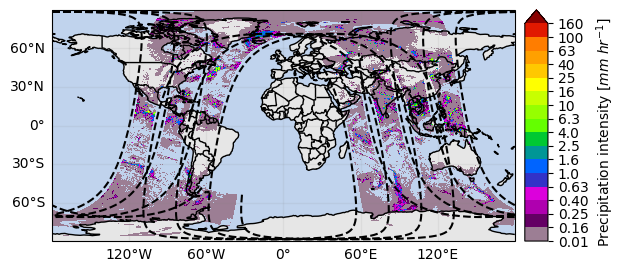

In [ ]:
da = ds[variable].isel(along_track=slice(0, 8000))
da.gpm.plot_map()

You can customize the map projection by passing a `cartopy.crs.Projection` to the subplot. 
The available projections are [listed here]( https://scitools.org.uk/cartopy/docs/latest/reference/projections.html?highlight=projections).

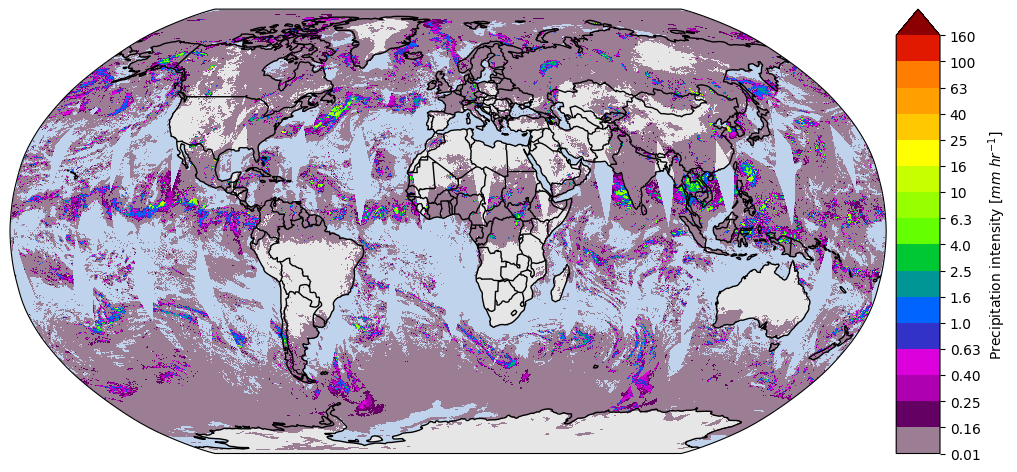

In [ ]:
# Define some figure options
dpi = 100
figsize = (12, 10)

# Example of Cartopy projections
crs_proj = ccrs.Robinson()  # ccrs.Orthographic(180, -90)

# Select a single variable
da = ds[variable]

# Create the map
fig, ax = plt.subplots(subplot_kw={"projection": crs_proj}, figsize=figsize, dpi=dpi)
da.gpm.plot_map(ax=ax, add_labels=False, add_background=True, add_gridlines=False, add_swath_lines=False)
ax.set_global()

By focusing on a narrow region, it's possible to better visualize the spatial field:

Text(0.5, 1.0, '2A-MHS-METOPB-CLIM SurfacePrecipitation')

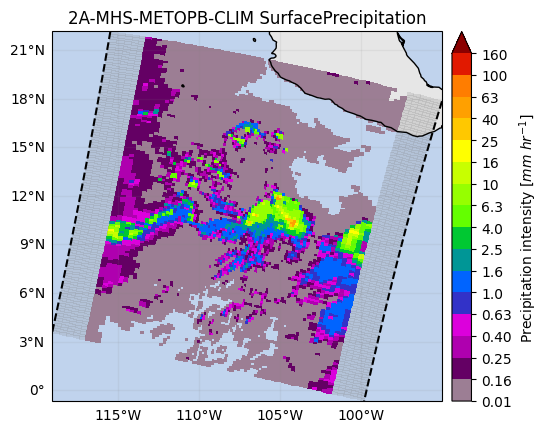

In [ ]:
p = ds[variable].gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id)).gpm.plot_map()
p.axes.set_title(ds[variable].gpm.title(add_timestep=False))

Using the `gpm.plot_image` method is possible to visualize the data in the so-called "swath scan view":


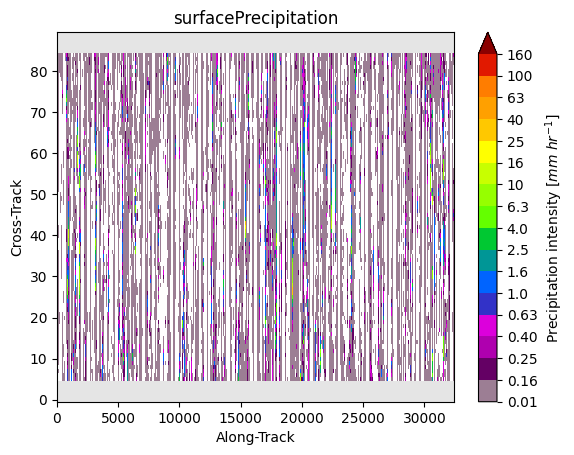

In [ ]:
da.gpm.plot_image()

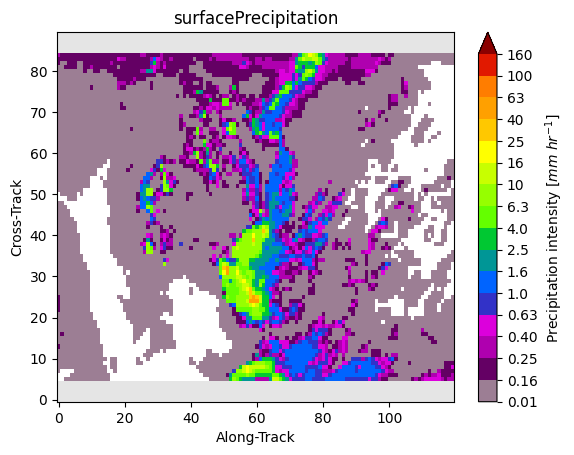

In [ ]:
ds[variable].gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id)).gpm.plot_image()

When we visualize different product variables, GPM-API will automatically try to use different appropriate colormaps and colorbars. 
You can observe this in the following example:

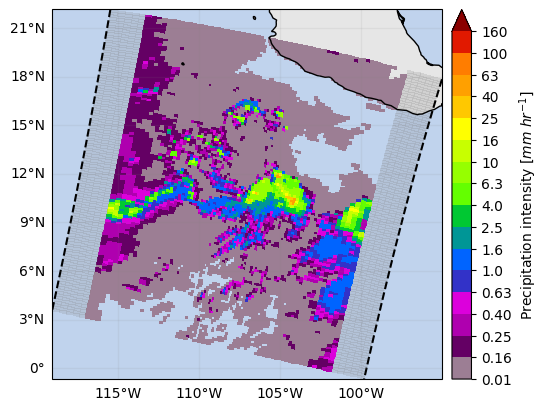

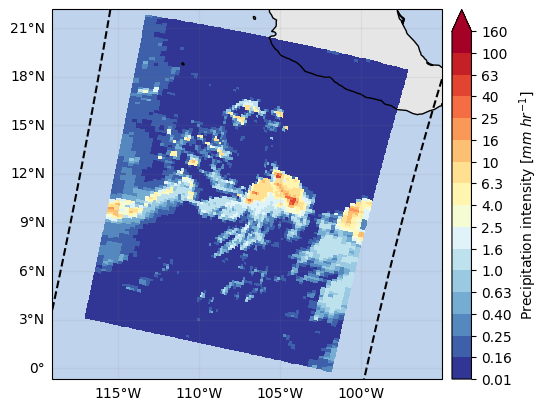

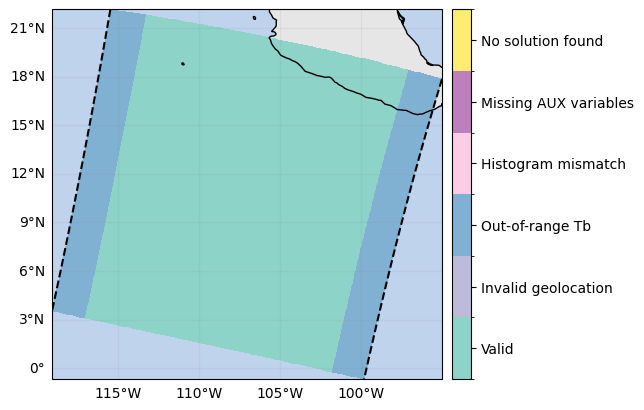

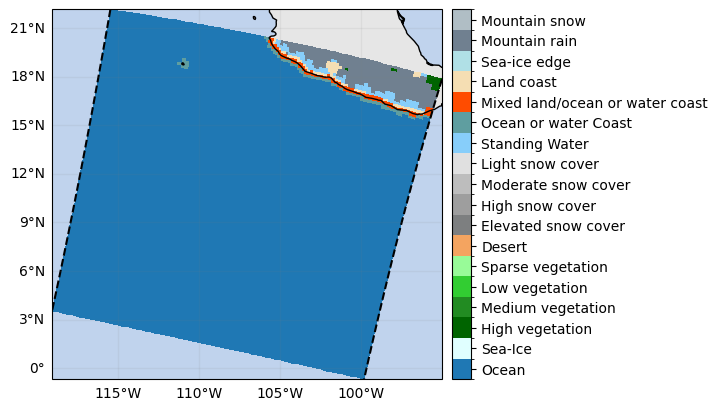

In [ ]:
ds_subset = ds.gpm.sel(gpm_id=slice(start_gpm_id, end_gpm_id))
ds_subset["surfacePrecipitation"].gpm.plot_map()
ds_subset["surfacePrecipitation"].gpm.plot_map(cmap="RdYlBu_r")  # ex: enable to modify defaults parameters on the fly
ds_subset["pixelStatus"].gpm.plot_map()  # ex: defaults to categorical colorbar
ds_subset["surfaceTypeIndex"].gpm.plot_map()  # ex: defaults to categorical colorbar

The registered colorbar configurations can be displayed using `gpm.colorbars.show_colorbars()` and the `plot_kwargs` and `cbar_kwargs` required to customize the figure can be obtained by calling the `gpm.get_plot_kwargs` function. Here below we provide an example on how to display PMW precipitation rates estimates using the same colorbar used by NASA to display IMERG liquid precipitation estimates.


GPM-API provides colormaps and colorbars tailored to GPM product variables with the goal of simplifying the data analysis and make it more reproducible.

The default colormap and colorbar configurations are defined into YAML files into the [gpm/etc/colorbars directory](https://github.com/ghiggi/gpm_api/blob/main/gpm/etc/colorbars/) of the software.

However, users are free to override, add and/or customize the colorbars configurations using the [pycolorbar](https://pycolorbar.readthedocs.io/en/latest/index.html) registry.


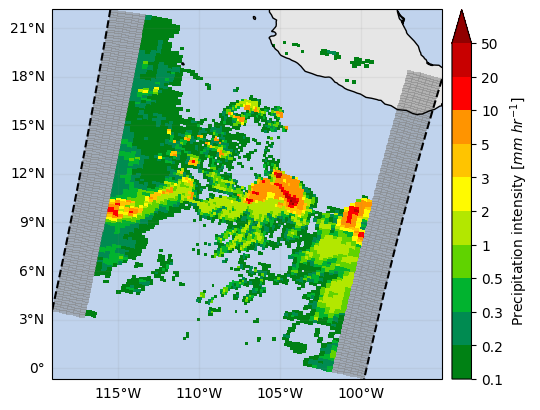

In [ ]:
plot_kwargs, cbar_kwargs = gpm.get_plot_kwargs("IMERG_Liquid")
ds_subset["surfacePrecipitation"].gpm.plot_map(cbar_kwargs=cbar_kwargs, **plot_kwargs)

## 5. Geospatial Manipulations

GPM-API provides methods to easily spatially subset orbits by extent, country or continent.

Note however, that an area can be crossed by multiple orbits depending on the size of your GPM satellite dataset. 
In other words, multiple orbit slices in along-track direction can intersect the area of interest. 

The method `get_crop_slices_by_extent`, `get_crop_slices_by_country` and ` get_crop_slices_by_continent` enable to retrieve the orbit portions intersecting the area of interest. 

[{'along_track': slice(3772, 4119, None)}, {'along_track': slice(6030, 6400, None)}, {'along_track': slice(8273, 8680, None)}, {'along_track': slice(10509, 10961, None)}, {'along_track': slice(12733, 12770, None)}, {'along_track': slice(12790, 13216, None)}, {'along_track': slice(14940, 15051, None)}, {'along_track': slice(15070, 15225, None)}, {'along_track': slice(17041, 17332, None)}, {'along_track': slice(17351, 17410, None)}, {'along_track': slice(19163, 19612, None)}, {'along_track': slice(19631, 19635, None)}, {'along_track': slice(21439, 21865, None)}, {'along_track': slice(23720, 24103, None)}, {'along_track': slice(26001, 26354, None)}, {'along_track': slice(28281, 28623, None)}]
[{'along_track': slice(3772, 4119, None)}, {'along_track': slice(6030, 6400, None)}, {'along_track': slice(8273, 8680, None)}, {'along_track': slice(10509, 10961, None)}, {'along_track': slice(12733, 12770, None)}, {'along_track': slice(12790, 13216, None)}, {'along_track': slice(14940, 15051, None)}

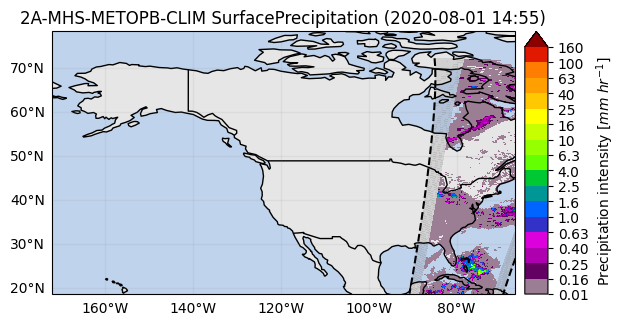

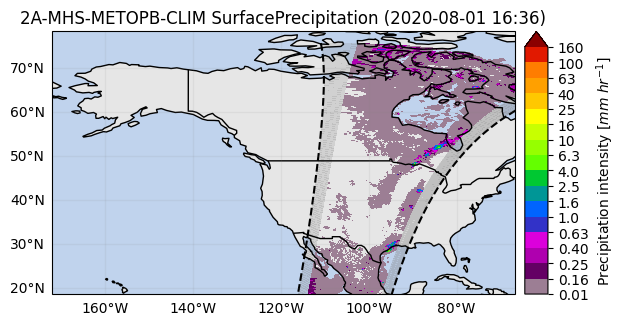

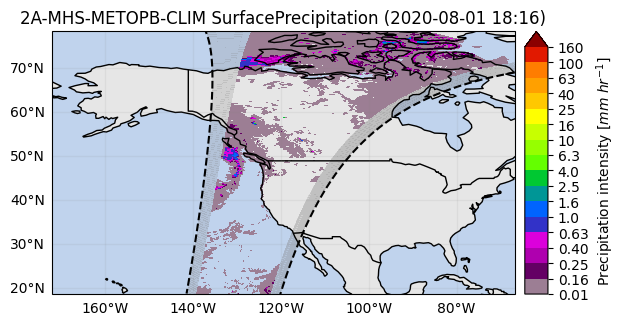

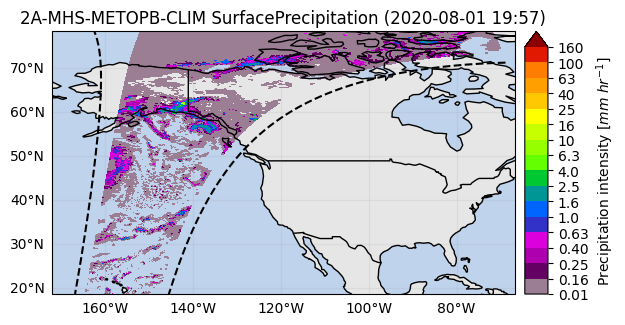

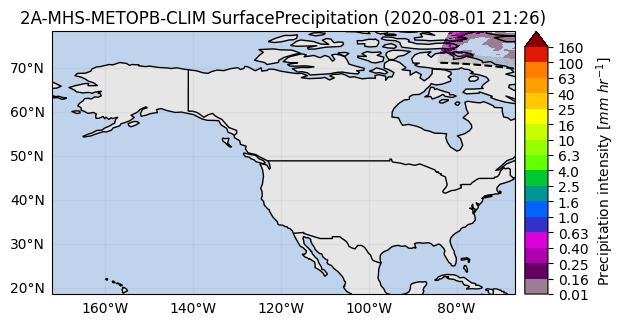

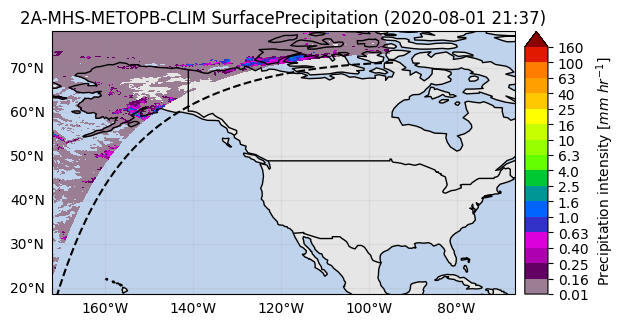

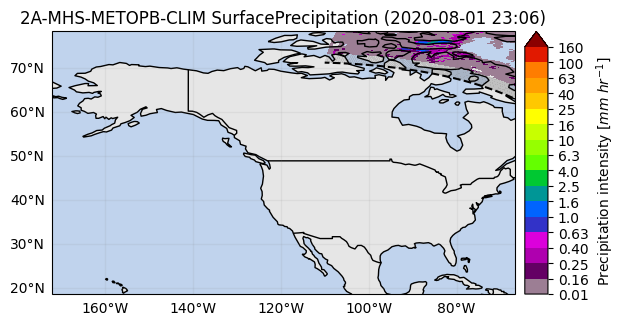

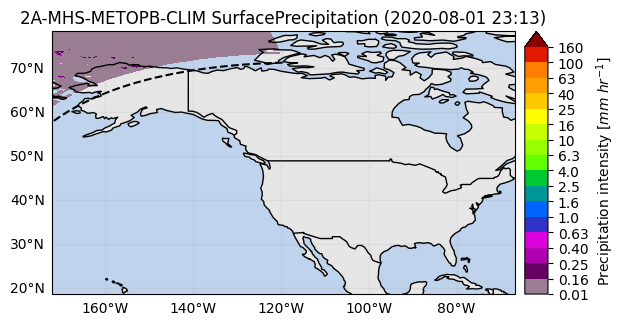

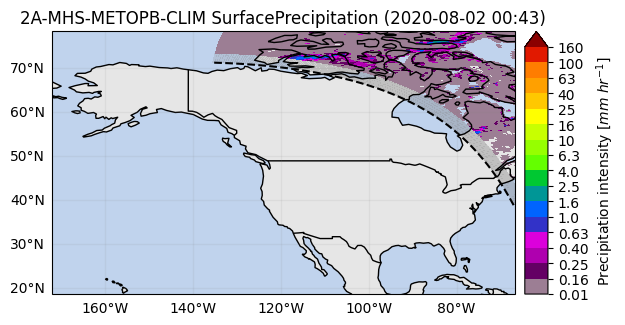

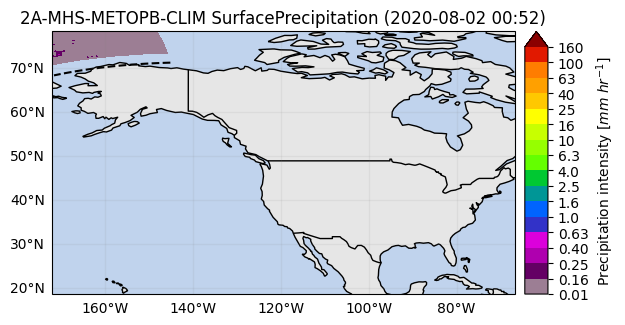

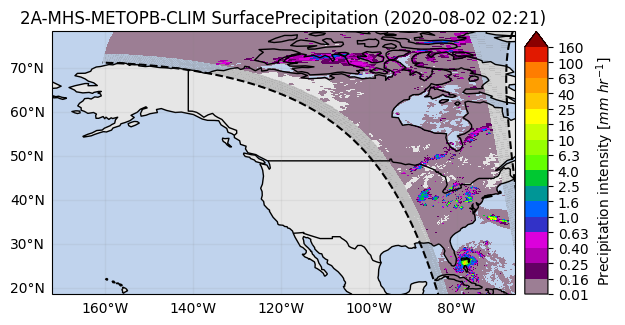

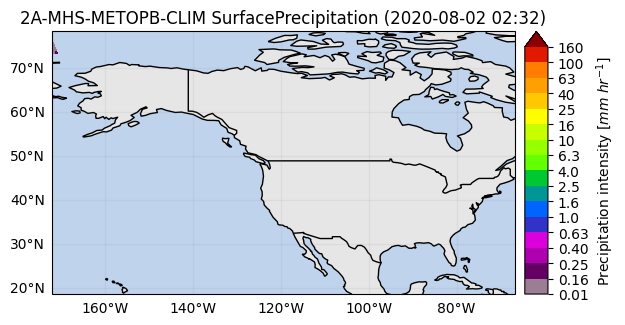

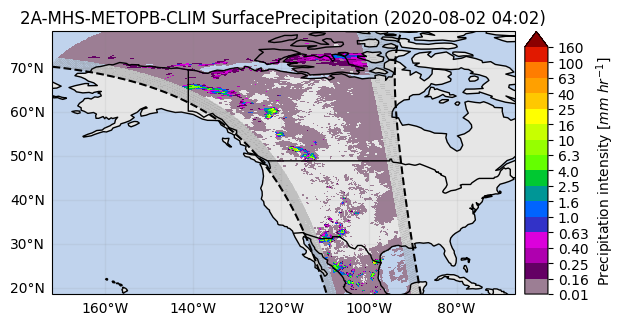

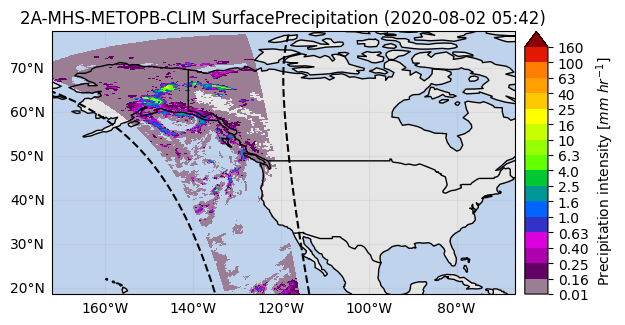

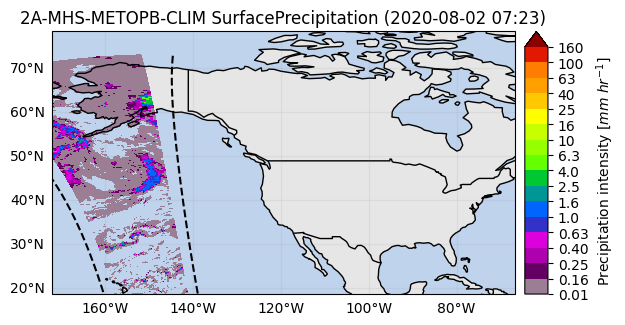

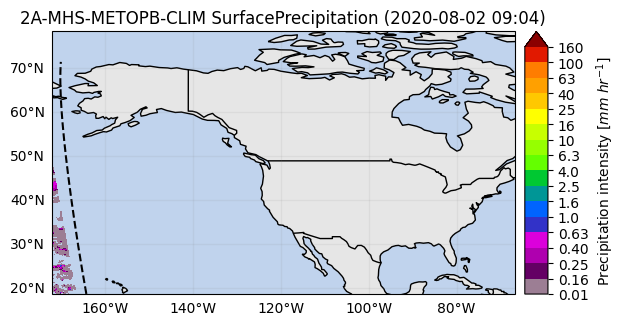

In [ ]:
# Define the variable to display
variable = "surfacePrecipitation"

# Crop by country
list_isel_dict = ds.gpm.get_crop_slices_by_country("United States")
print(list_isel_dict)

# Crop by extent
extent = get_country_extent("United States")
list_isel_dict = ds.gpm.get_crop_slices_by_extent(extent)
print(list_isel_dict)

# Plot the swaths crossing the country
for isel_dict in list_isel_dict:
    da_subset = ds[variable].isel(isel_dict)
    slice_title = da_subset.gpm.title(add_timestep=True)
    p = da_subset.gpm.plot_map()
    p.axes.set_extent(extent)
    p.axes.set_title(label=slice_title)

You can also easily obtain the extent around a given point (i.e. ground radar location) using the `get_geographic_extent_around_point` function and use 
the gpm accessor methods `get_crop_slices_around_point` or `crop_around_point` to subset your dataset:

[{'along_track': slice(6353, 6380, None)}, {'along_track': slice(21454, 21481, None)}]
[{'along_track': slice(6353, 6380, None)}, {'along_track': slice(21454, 21481, None)}]


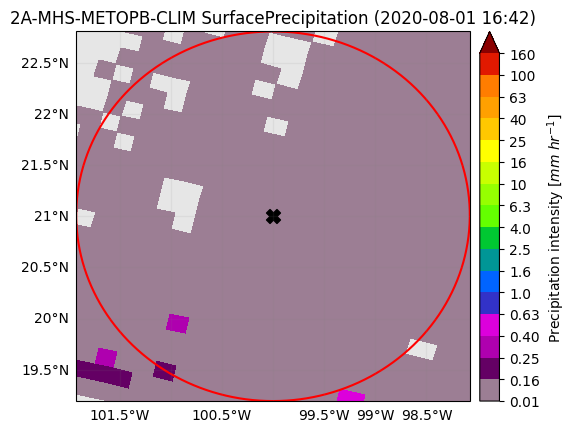

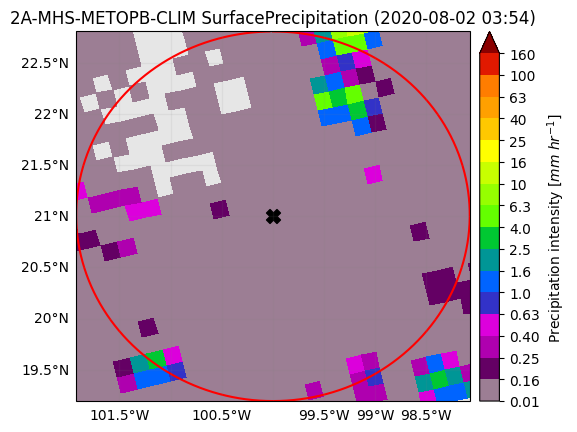

In [ ]:
# Define the variable to display
variable = "surfacePrecipitation"

# Crop around a point (i.e. radar location)
lon = -100
lat = 21
distance = 200_000  # 200 km
list_isel_dict = ds.gpm.get_crop_slices_around_point(
    lon=lon,
    lat=lat,
    distance=distance,
)
print(list_isel_dict)

extent = get_geographic_extent_around_point(lon=lon, lat=lat, distance=distance)
list_isel_dict = ds.gpm.get_crop_slices_by_extent(extent)
print(list_isel_dict)

# Define ROI coordinates
circle_lons, circle_lats = get_circle_coordinates_around_point(
    lon,
    lat,
    radius=distance,
    num_vertices=360,
)

# Plot the swaths crossing the ROI
for isel_dict in list_isel_dict:
    da_subset = ds[variable].isel(isel_dict)
    slice_title = da_subset.gpm.title(add_timestep=True)
    p = da_subset.gpm.plot_map()
    p.axes.set_title(slice_title)
    p.axes.plot(circle_lons, circle_lats, "r-", transform=ccrs.Geodetic())
    p.axes.scatter(lon, lat, c="black", marker="X", s=100, transform=ccrs.Geodetic())
    p.axes.set_extent(extent)

Please keep in mind that you can easily retrieve the extent of a GPM xarray object using the `extent` method. 

The optional argument `padding` allows to expand/shrink the geographic extent by custom lon/lat degrees, while the `size` argument allows 
to obtain an extent centered on the GPM object with the desired size.

In [ ]:
print(da_subset.gpm.extent(padding=0.1))  # expanding
print(da_subset.gpm.extent(padding=-0.1))  # shrinking
print(da_subset.gpm.extent(size=0.5))
print(da_subset.gpm.extent(size=0))  # centroid

Extent(xmin=-109.97310028076171, xmax=-88.70780029296876, ymin=16.570400619506835, ymax=25.20149955749512)
Extent(xmin=-109.77310028076172, xmax=-88.90780029296874, ymin=16.770400619506837, ymax=25.001499557495116)
Extent(xmin=-99.59045028686523, xmax=-99.09045028686523, ymin=20.635950088500977, ymax=21.135950088500977)
Extent(xmin=-99.34045028686523, xmax=-99.34045028686523, ymin=20.885950088500977, ymax=20.885950088500977)


## 6 Storm Labeling

Using the xarray `ximage` accessor, it is possible to easily delineate (label) the precipitating areas. The label array is added to the dataset as a new coordinate.

The array currently contains 416 labels and 'max_n_labels'
            is set to 50. The colorbar is not displayed!


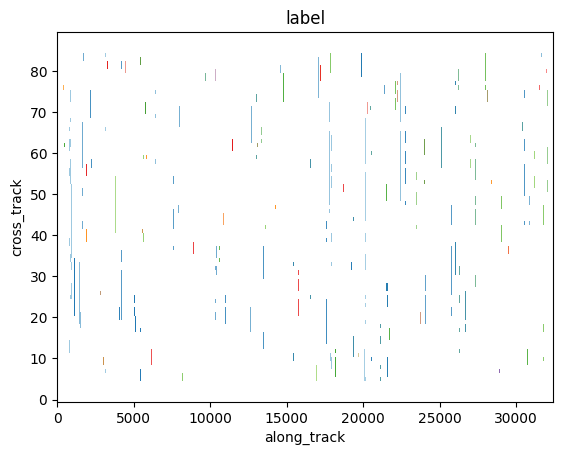

In [ ]:
# Retrieve labeled xarray object
label_name = "label"
ds = ds.ximage.label(
    variable="surfacePrecipitation",
    min_value_threshold=1,
    min_area_threshold=5,
    footprint=5,  # assign same label to precipitating areas 5 pixels apart
    sort_by="area",  # "maximum", "minimum", <custom_function>
    sort_decreasing=True,
    label_name=label_name,
)
# Plot full label array
ds[label_name].ximage.plot_labels()

Let's zoom in a specific region:

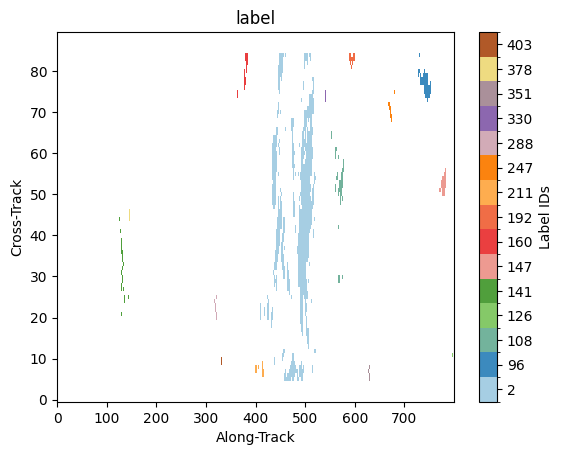

In [ ]:
gpm.plot_labels(ds[label_name].isel(along_track=slice(2700, 3500)))

## 7. Patch Extraction

With the xarray `ximage` accessor, it is also possible to extract patches around the precipitating areas. Here we provide a minimal example on how to proceed:

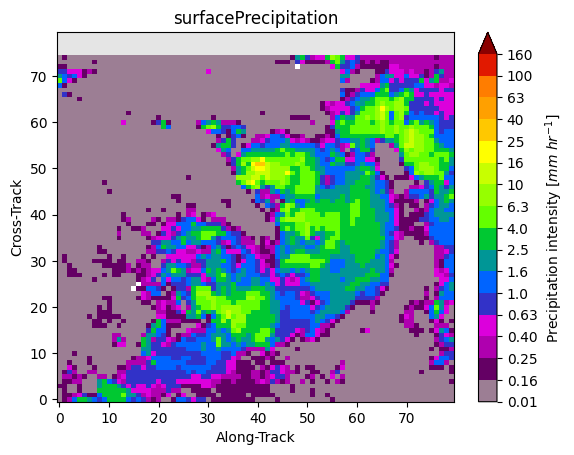

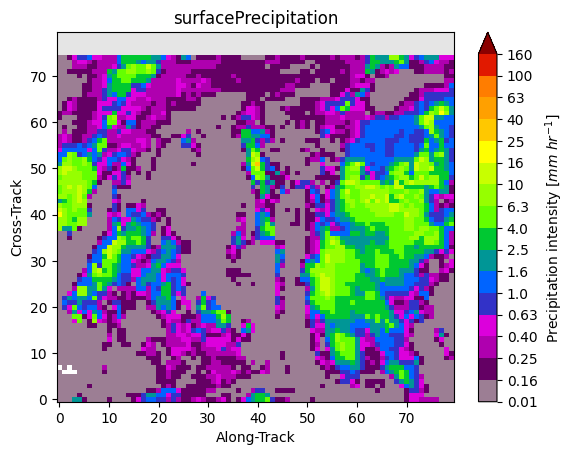

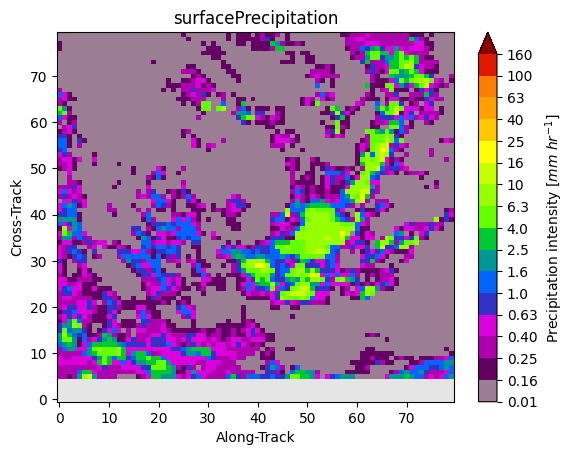

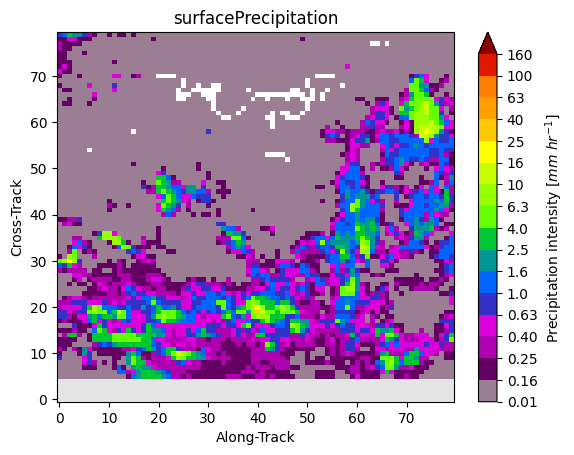

In [ ]:
# Define the patch generator
da_patch_gen = ds["surfacePrecipitation"].ximage.label_patches(
    label_name=label_name,
    patch_size=(80, 80),
    # Output options
    n_patches=4,
    # Patch extraction Options
    padding=0,
    centered_on="max",
    # Tiling/Sliding Options
    debug=False,
    verbose=False,
)

# # Retrieve list of patches
list_label_patches = list(da_patch_gen)
list_da = [da for label, da in list_label_patches]

# Display patches
gpm.plot_patches(list_label_patches)

You can exploit the xarray manipulations and FacetGrid capabilities to quickly create the following figure:

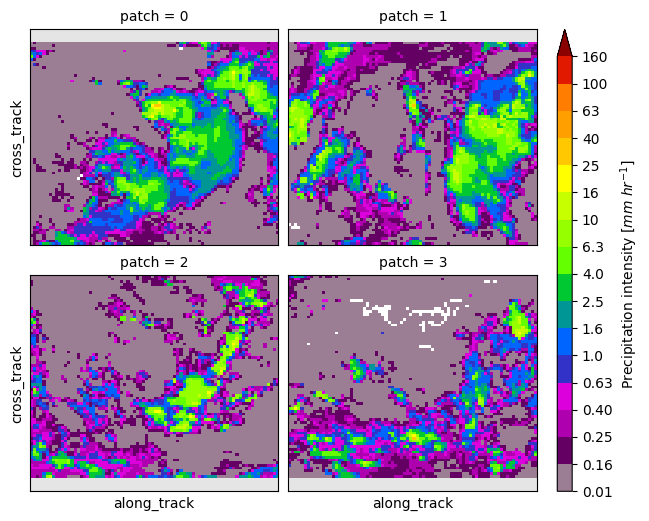

In [ ]:
list_da_without_coords = [da.drop_vars(["lon", "lat"]) for da in list_da]
da_patch = xr.concat(list_da_without_coords, dim="patch")
da_patch.isel(patch=slice(0, 4)).gpm.plot_image(col="patch", col_wrap=2)